In [1]:
#!/usr/bin/env python3
import time, argparse, logging, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from statsmodels.stats.power import TTestPower
from sklearn.preprocessing import LabelEncoder, PowerTransformer
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_curve, auc, brier_score_loss,
    classification_report, confusion_matrix
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from joblib import Parallel, delayed
import joblib

# -----------------------------------------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

DATA_PATH = Path(r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv")
FEATURES = [
    "Frac_Extreme_X_std", "State_Occupancy_Entropy_std",
    "Fixation_Deviation_Variance_kurtosis_func", "mean_saccade_amplitude_std",
    "nu_mean", "r_mean", "mt_std", "beta_std",
    "gazedur_exp", "totaltime_exp",
    "std_saccade_velocity_skew", "mean_fixation_duration_median",
    "Self_Transition_Ratio_Count_mean", "Entropy_Deviation_std"
]
GROUPS = {
    "Markov": [
        "Frac_Extreme_X_std",
        "State_Occupancy_Entropy_std",
        "Fixation_Deviation_Variance_kurtosis_func",
        "Self_Transition_Ratio_Count_mean",
        "Entropy_Deviation_std",
    ],
    "SWIFT": ["nu_mean", "r_mean", "mt_std", "beta_std"],
    "Complementary": [
        "gazedur_exp", "totaltime_exp",
        "std_saccade_velocity_skew",
        "mean_fixation_duration_median",
        "mean_saccade_amplitude_std",
    ],
}
TARGET = "Group"
RANDOM_STATE = 42
OUT_MODEL = "svm_pipeline_final.pkl"

# -----------------------------------------------------------------------------
def summarize_data(df, features, target, le):
    log.info(f"Dataset: {len(df)} samples, {len(features)} features")
    log.info("Class counts:\n%s", df[target].value_counts().to_string())
    # no missing / imbalance assumed

# -----------------------------------------------------------------------------
def build_pipeline():
    return Pipeline([
        ("scaler", PowerTransformer(method="yeo-johnson")),
        ("clf", SVC(probability=True, class_weight="balanced",
                    random_state=RANDOM_STATE))
    ])

# -----------------------------------------------------------------------------
def nested_cv_evaluate(X, y, le):
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        build_pipeline(),
        {"clf__kernel": ["linear"], "clf__C": [1,10,100]},
        scoring="roc_auc", cv=inner, n_jobs=-1, refit=True
    )

    all_probs = np.zeros(len(y))
    fold_aucs = []
    for fold, (tr, te) in enumerate(outer.split(X, y), 1):
        grid.fit(X[tr], y[tr])
        probs = grid.predict_proba(X[te])[:,1]
        all_probs[te] = probs
        fpr, tpr, _ = roc_curve(y[te], probs)
        a = auc(fpr, tpr)
        fold_aucs.append(a)
        log.info(f"Fold {fold} ROC‐AUC = {a:.3f}")

    mean_auc = np.mean(fold_aucs)
    lo_f, hi_f = np.percentile(fold_aucs, [2.5,97.5])
    log.info(f"Nested CV AUC: {mean_auc:.3f} (95% fold‐CI [{lo_f:.3f},{hi_f:.3f}])")

    # bootstrap overall AUC
    B = 1000
    rng = np.random.RandomState(RANDOM_STATE)
    boots = [ roc_auc_score(y[idx], all_probs[idx])
              for idx in (rng.choice(len(y), len(y), replace=True)
                          for _ in range(B)) ]
    lo_b, hi_b = np.percentile(boots, [2.5,97.5])
    log.info(f"Bootstrap AUC CI: 95% CI [{lo_b:.3f},{hi_b:.3f}]")

    # pick threshold = .5
    thresh = 0.5
    preds = (all_probs >= thresh).astype(int)
    print(classification_report(y, preds, target_names=le.classes_))
    cm = confusion_matrix(y, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion @ t={thresh}")
    plt.tight_layout(); plt.show()

    # final fit
    grid.fit(X, y)
    return grid.best_estimator_, all_probs, thresh

# -----------------------------------------------------------------------------
def plot_calibration(y, probs, n_bins=5):
    frac_pos, mean_pred = calibration_curve(y, probs,
                                            n_bins=n_bins, strategy="quantile")
    bs = brier_score_loss(y, probs)
    log.info(f"Brier score = {bs:.3f}")

    plt.figure(figsize=(6,6))
    plt.plot(mean_pred, frac_pos, "s-", label="Hybrid")
    plt.plot([0,1],[0,1],"k--", label="Ideal")
    plt.xlabel("Mean predicted")
    plt.ylabel("Observed freq")
    plt.title("Calibration curve")
    plt.legend()
    plt.tight_layout(); plt.show()

# -----------------------------------------------------------------------------
def compute_permutation_importance(X, y, n_boot=200, alpha=0.05):
    rng = np.random.RandomState(RANDOM_STATE)
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    all_bs = []

    for fold, (tr, te) in enumerate(outer.split(X,y),1):
        Xtr,ytr,Xte,yte = X[tr],y[tr], X[te],y[te]
        seeds = rng.randint(0,2**31-1,size=n_boot)
        def one(s):
            rs = np.random.RandomState(s)
            idx = rs.randint(0,len(ytr),len(ytr))
            pipe = build_pipeline()
            pipe.fit(Xtr[idx],ytr[idx])
            imp = permutation_importance(pipe, Xte, yte,
                                         n_repeats=5, random_state=rs,
                                         scoring="roc_auc")
            return imp.importances_mean
        bs = np.vstack(Parallel(n_jobs=-1)(delayed(one)(s) for s in seeds))
        all_bs.append(bs)
        log.info(f"Fold {fold} perm‐boot done")

    all_bs = np.vstack(all_bs)
    m_feat = all_bs.mean(0)
    lo_feat, hi_feat = np.percentile(all_bs, [alpha/2*100, (1-alpha/2)*100], axis=0)

    order = np.argsort(m_feat)[::-1]
    print("\nFeature ΔAUC (mean±95% CI):")
    for i in order:
        print(f"  {FEATURES[i]:30s}{m_feat[i]:.3f} [{lo_feat[i]:.3f},{hi_feat[i]:.3f}]")

    # group‐level sums
    group_vals = {}
    for g, feats in GROUPS.items():
        idxs = [FEATURES.index(f) for f in feats]
        group_vals[g] = all_bs[:,idxs].sum(1)

    print("\nGroup ΔAUC (mean±95% CI, Cohen’s d, power):")
    power = TTestPower()
    names = list(group_vals.keys())
    for i in range(len(names)):
        for j in range(i+1,len(names)):
            d = group_vals[names[i]] - group_vals[names[j]]
            lo, hi = np.percentile(d, [alpha/2*100, (1-alpha/2)*100])
            d_eff = d.mean()/d.std(ddof=1)
            pw = power.power(effect_size=d_eff,
                             nobs=len(d),
                             alpha=alpha,
                             alternative="two-sided")
            print(f"  {names[i]} vs {names[j]:<12s}"
                  f"[{lo:.3f},{hi:.3f}], d={d_eff:.3f}, power={pw:.3f}")

# -----------------------------------------------------------------------------
def compute_shap_importance(pipe, X, n_boot=200, alpha=0.05):
    bg = shap.sample(X, min(50,len(X)), random_state=RANDOM_STATE)
    expl = shap.KernelExplainer(lambda d: pipe.predict_proba(d)[:,1], bg)
    shap_vals = expl.shap_values(X, nsamples=200)
    abs_s = np.abs(shap_vals)

    m_s = abs_s.mean(0)
    bs = []
    rng = np.random.RandomState(RANDOM_STATE+1)
    for _ in range(n_boot):
        idx = rng.randint(0,len(X),len(X))
        bs.append(abs_s[idx].mean(0))
    bs = np.vstack(bs)
    lo_s, hi_s = np.percentile(bs, [alpha/2*100,(1-alpha/2)*100], axis=0)

    order = np.argsort(m_s)[::-1]
    print("\nSHAP |mean| (mean±95% CI):")
    for i in order:
        print(f"  {FEATURES[i]:30s}{m_s[i]:.3f} [{lo_s[i]:.3f},{hi_s[i]:.3f}]")

    # group‐level
    print("\nSHAP group‐level |mean| (95% CI):")
    for g, feats in GROUPS.items():
        idxs = [FEATURES.index(f) for f in feats]
        vals = abs_s[:,idxs].sum(1)
        bs_g = []
        for _ in range(n_boot):
            idx = rng.randint(0,len(vals),len(vals))
            bs_g.append(vals[idx].mean())
        lo_g, hi_g = np.percentile(bs_g, [alpha/2*100,(1-alpha/2)*100])
        print(f"  {g:15s}{vals.mean():.3f} [{lo_g:.3f},{hi_g:.3f}]")

# -----------------------------------------------------------------------------
def main():
    start = time.time()
    parser = argparse.ArgumentParser()
    parser.add_argument("--data-path", type=str, help="CSV override")
    args, _ = parser.parse_known_args()

    df = pd.read_csv(args.data_path or DATA_PATH)
    le = LabelEncoder()
    y = le.fit_transform(df[TARGET])
    X = df[FEATURES].values

    summarize_data(df, FEATURES, TARGET, le)
    pipe, probs, thresh = nested_cv_evaluate(X, y, le)
    plot_calibration(y, probs)
    compute_permutation_importance(X, y)
    compute_shap_importance(pipe, X)

    joblib.dump({"pipe":pipe,"thresh":thresh}, OUT_MODEL)
    log.info("Saved → %s", OUT_MODEL)
    log.info("Total runtime: %.1fs", time.time()-start)

if __name__ == "__main__":
    main()


2025-05-09 17:25:44,622 INFO Dataset: 100 samples, 14 features
2025-05-09 17:25:44,628 INFO Class counts:
Group
ADHD    50
TD      50
2025-05-09 17:25:47,651 INFO Fold 1 ROC‐AUC = 0.840
2025-05-09 17:25:50,940 INFO Fold 2 ROC‐AUC = 0.860
2025-05-09 17:25:51,993 INFO Fold 3 ROC‐AUC = 0.820
2025-05-09 17:25:52,761 INFO Fold 4 ROC‐AUC = 0.770
2025-05-09 17:25:53,293 INFO Fold 5 ROC‐AUC = 0.910
2025-05-09 17:25:53,304 INFO Nested CV AUC: 0.840 (95% fold‐CI [0.775,0.905])


NameError: name 'roc_auc_score' is not defined

In [2]:
#!/usr/bin/env python3
import time, argparse, logging, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from statsmodels.stats.power import TTestPower

from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_curve, auc, brier_score_loss,
    classification_report, confusion_matrix, calibration_curve
)
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from joblib import Parallel, delayed
import joblib

# --- Setup -----------------------------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

# --- Constants -------------------------------------------------------------
DATA_PATH = Path(
    r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv"
)
FEATURES = [
    "Frac_Extreme_X_std", "State_Occupancy_Entropy_std",
    "Fixation_Deviation_Variance_kurtosis_func", "mean_saccade_amplitude_std",
    "nu_mean", "r_mean", "mt_std", "beta_std",
    "gazedur_exp", "totaltime_exp",
    "std_saccade_velocity_skew", "mean_fixation_duration_median",
    "Self_Transition_Ratio_Count_mean", "Entropy_Deviation_std"
]
GROUPS = {
    "Markov": [
        "Frac_Extreme_X_std",
        "State_Occupancy_Entropy_std",
        "Fixation_Deviation_Variance_kurtosis_func",
        "Self_Transition_Ratio_Count_mean",
        "Entropy_Deviation_std",
    ],
    "SWIFT": ["nu_mean", "r_mean", "mt_std", "beta_std"],
    "Complementary": [
        "gazedur_exp", "totaltime_exp",
        "std_saccade_velocity_skew",
        "mean_fixation_duration_median",
        "mean_saccade_amplitude_std",
    ],
}
TARGET = "Group"
RANDOM_STATE = 42
OUT_MODEL = "svm_pipeline_full_auc_tuned.pkl"

# -----------------------------------------------------------------------------
def summarize_data(df, features, target, le):
    log.info("Dataset size: %d samples, %d features", df.shape[0], len(features))
    log.info("Class distribution:\n%s", df[target].value_counts().to_string())
    missing = df[features].isna().sum()
    log.info("Missing per feature:\n%s", missing.to_string())
    missing_pct = df[features].isna().mean() * 100
    log.info("Missing percentages:\n%s", missing_pct.to_string())
    log.info("Label mapping: %s", dict(enumerate(le.classes_)))

# -----------------------------------------------------------------------------
def load_df(path: Path):
    log.info("Loading data from %s", path)
    df = pd.read_csv(path)
    missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    return df

# -----------------------------------------------------------------------------
def build_pipeline(with_smote=True):
    steps = [
        ("scaler", 
         PowerTransformer(method="yeo-johnson")),
    ]
    if with_smote:
        steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
    steps.append(("clf", SVC(
        probability=True,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )))
    return Pipeline(steps)

# -----------------------------------------------------------------------------
def nested_cv_evaluate(X, y, le):
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        build_pipeline(),
        param_grid={
            "clf__kernel": ["linear"],
            "clf__C": [1, 10, 100],
            "clf__gamma": ["scale"]
        },
        scoring="roc_auc",
        cv=inner,
        n_jobs=-1,
        refit=True
    )

    all_probs = np.zeros(len(y))
    fold_aucs = []
    for fold, (tr, te) in enumerate(outer.split(X, y), 1):
        grid.fit(X[tr], y[tr])
        probs = grid.predict_proba(X[te])[:, 1]
        all_probs[te] = probs
        fpr, tpr, _ = roc_curve(y[te], probs)
        fa = auc(fpr, tpr)
        fold_aucs.append(fa)
        log.info(f"Fold {fold}: AUC={fa:.3f}")

    mean_auc = np.mean(fold_aucs)
    lo_f, hi_f = np.percentile(fold_aucs, [2.5, 97.5])
    log.info(f"Nested CV AUC: {mean_auc:.3f} (folds 95% CI [{lo_f:.3f}, {hi_f:.3f}])")

    # bootstrap CI
    rng = np.random.RandomState(RANDOM_STATE)
    B = 1000
    boots = []
    for _ in range(B):
        idx = rng.choice(len(y), len(y), replace=True)
        boots.append(roc_auc_score(y[idx], all_probs[idx]))
    lo_b, hi_b = np.percentile(boots, [2.5, 97.5])
    log.info(f"Bootstrap AUC CI: 95% CI [{lo_b:.3f}, {hi_b:.3f}]")

    # classification at t=0.5
    thresh = 0.5
    preds = (all_probs >= thresh).astype(int)
    print(classification_report(y, preds, target_names=le.classes_))
    cm = confusion_matrix(y, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix @ t={thresh}")
    plt.tight_layout()
    plt.show()

    # full‐data retrain
    grid.fit(X, y)
    return grid.best_estimator_, all_probs, thresh

# -----------------------------------------------------------------------------
def compute_permutation_importance(X, y, n_bootstraps=200, alpha=0.05):
    log.info("Computing bootstrapped permutation importances…")
    rng = np.random.RandomState(RANDOM_STATE)
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    all_bs = []
    for fold, (tr, te) in enumerate(outer.split(X, y), 1):
        X_tr, y_tr = X[tr], y[tr]
        X_te, y_te = X[te], y[te]
        seeds = rng.randint(0, 2**31 - 1, size=n_bootstraps)
        def one_boot(s):
            rs = np.random.RandomState(s)
            idx = rs.randint(0, len(y_tr), len(y_tr))
            pipe = build_pipeline().fit(X_tr[idx], y_tr[idx])
            imp = permutation_importance(
                pipe, X_te, y_te,
                n_repeats=5, random_state=rs, scoring="roc_auc"
            )
            return imp.importances_mean
        bs = np.vstack(Parallel(n_jobs=-1)(
            delayed(one_boot)(s) for s in seeds
        ))
        log.info(f"Fold {fold} done")
        all_bs.append(bs)

    all_bs = np.vstack(all_bs)
    feat_mean = all_bs.mean(0)
    feat_lo   = np.percentile(all_bs, 100*(alpha/2), axis=0)
    feat_hi   = np.percentile(all_bs, 100*(1-alpha/2), axis=0)

    order = np.argsort(feat_mean)[::-1]
    print("\nFeature ΔAUC (mean ± 95% CI):")
    for i in order:
        print(f"  {FEATURES[i]:30s}{feat_mean[i]:.3f} "
              f"[{feat_lo[i]:.3f}, {feat_hi[i]:.3f}]")

    # group sums
    group_bs = {
        g: all_bs[:, [FEATURES.index(f) for f in feats]].sum(1)
        for g, feats in GROUPS.items()
    }
    print("\nGroup ΔAUC (mean ± 95% CI):")
    for g, vals in group_bs.items():
        m = vals.mean()
        lo, hi = np.percentile(vals, [100*(alpha/2), 100*(1-alpha/2)])
        print(f"  {g:15s}{m:.3f} [{lo:.3f}, {hi:.3f}]")

    # pairwise CIs & paired‐t power
    print("\nGroup differences (95% CI) + post‐hoc paired‐t power:")
    power = TTestPower()
    names = list(group_bs)
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            dif = group_bs[names[i]] - group_bs[names[j]]
            lo, hi = np.percentile(dif, [100*(alpha/2), 100*(1-alpha/2)])
            d_eff = dif.mean() / dif.std(ddof=1)
            pw = power.power(effect_size=d_eff,
                             nobs=len(dif),
                             alpha=alpha, ratio=1.0, alternative='two-sided')
            print(f"  {names[i]} vs {names[j]:<12s}"
                  f"[{lo:.3f}, {hi:.3f}], d={d_eff:.3f}, power={pw:.3f}")

# -----------------------------------------------------------------------------
def compute_shap_importance(pipe, X, alpha=0.05, n_bootstraps=200):
    log.info("Computing SHAP importances…")
    bg = shap.sample(X, min(50, len(X)), random_state=RANDOM_STATE)
    explainer = shap.KernelExplainer(lambda d: pipe.predict_proba(d)[:,1], bg)
    vals = explainer.shap_values(X, nsamples=200)
    abs_shap = np.abs(vals)

    feat_mean = abs_shap.mean(0)
    # bootstrap
    rng = np.random.RandomState(RANDOM_STATE+1)
    bs = []
    for _ in range(n_bootstraps):
        idx = rng.randint(0, len(X), len(X))
        bs.append(abs_shap[idx].mean(0))
    bs = np.vstack(bs)
    lo = np.percentile(bs, 100*(alpha/2), axis=0)
    hi = np.percentile(bs, 100*(1-alpha/2), axis=0)

    order = np.argsort(feat_mean)[::-1]
    print("\nSHAP |mean| (mean ± 95% CI):")
    for i in order:
        print(f"  {FEATURES[i]:30s}{feat_mean[i]:.3f} "
              f"[{lo[i]:.3f}, {hi[i]:.3f}]")

    # group‐level SHAP
    print("\nSHAP group |mean| (mean ± 95% CI):")
    for g, feats in GROUPS.items():
        idxs = [FEATURES.index(f) for f in feats]
        vals = abs_shap[:, idxs].sum(1)
        bs_vals = []
        for _ in range(n_bootstraps):
            subs = rng.randint(0, len(vals), len(vals))
            bs_vals.append(vals[subs].mean())
        lo2, hi2 = np.percentile(bs_vals, [100*(alpha/2), 100*(1-alpha/2)])
        print(f"  {g:15s}{vals.mean():.3f} [{lo2:.3f}, {hi2:.3f}]")

# -----------------------------------------------------------------------------
def plot_calibration(y, probs):
    log.info("Plotting calibration curve + Brier score")
    frac_pos, pred_mean = calibration_curve(y, probs, n_bins=10)
    brier = brier_score_loss(y, probs)
    plt.figure(figsize=(6,6))
    plt.plot(pred_mean, frac_pos, "s-", label="Model")
    plt.plot([0,1], [0,1], "--", color="gray")
    plt.xlabel("Mean predicted")
    plt.ylabel("Fraction positive")
    plt.title(f"Calibration (Brier={brier:.3f})")
    plt.legend()
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
def main():
    start = time.time()
    df = load_df(DATA_PATH)
    le = LabelEncoder()
    X = df[FEATURES].values
    y = le.fit_transform(df[TARGET])

    summarize_data(df, FEATURES, TARGET, le)
    pipe, probs, thresh = nested_cv_evaluate(X, y, le)
    plot_calibration(y, probs)
    compute_permutation_importance(X, y)
    compute_shap_importance(pipe, X)

    # save
    joblib.dump({"pipeline": pipe, "threshold": thresh}, OUT_MODEL)
    log.info("Saved → %s", OUT_MODEL)

    log.info(f"Total runtime: {(time.time()-start):.1f}s")

if __name__ == "__main__":
    main()


ImportError: cannot import name 'calibration_curve' from 'sklearn.metrics' (C:\Users\MEHRAN\anaconda3\Lib\site-packages\sklearn\metrics\__init__.py)

2025-05-09 17:26:45,850 INFO Loading data from D:\ACIT Master's Thesis\New data\Colab_eyetracking\stories\new_version03\merged_output100.csv
2025-05-09 17:26:45,870 INFO Dataset size: 100 samples, 14 features
2025-05-09 17:26:45,872 INFO Class distribution:
Group
ADHD    50
TD      50
2025-05-09 17:26:45,875 INFO Missing per feature:
Frac_Extreme_X_std                           0
State_Occupancy_Entropy_std                  0
Fixation_Deviation_Variance_kurtosis_func    0
mean_saccade_amplitude_std                   0
nu_mean                                      0
r_mean                                       0
mt_std                                       0
beta_std                                     0
gazedur_exp                                  0
totaltime_exp                                0
std_saccade_velocity_skew                    0
mean_fixation_duration_median                0
Self_Transition_Ratio_Count_mean             0
Entropy_Deviation_std                        0
2025-0

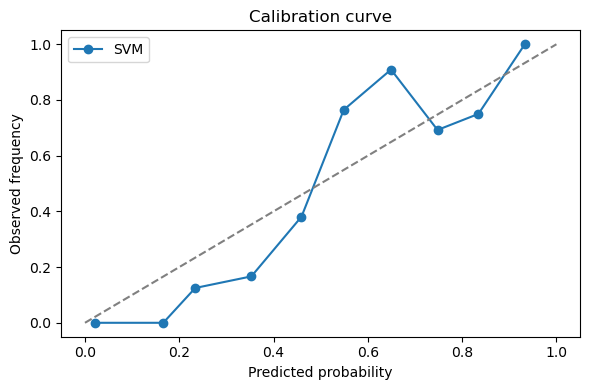

2025-05-09 17:26:47,238 INFO Sensitivity: 0.780, Specificity: 0.780



Classification Report (Nested CV):
              precision    recall  f1-score   support

        ADHD       0.78      0.78      0.78        50
          TD       0.78      0.78      0.78        50

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100



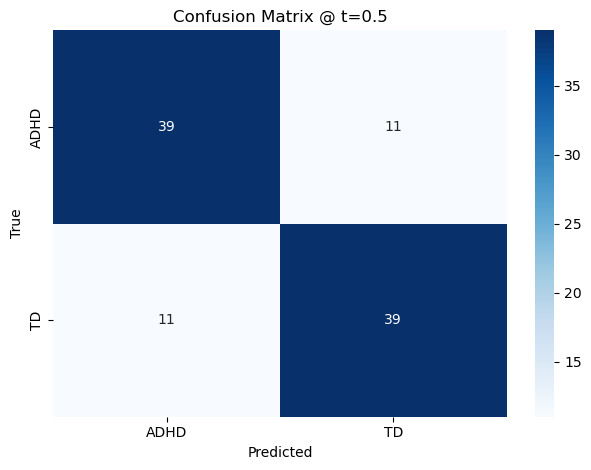

2025-05-09 17:26:55,068 INFO Completed fold 1 permutation bootstraps
2025-05-09 17:27:02,342 INFO Completed fold 2 permutation bootstraps
2025-05-09 17:27:09,682 INFO Completed fold 3 permutation bootstraps
2025-05-09 17:27:16,963 INFO Completed fold 4 permutation bootstraps
2025-05-09 17:27:24,202 INFO Completed fold 5 permutation bootstraps



Feature‐level ΔAUC (mean ± 95% CI):
  State_Occupancy_Entropy_std   0.048 [-0.044, 0.152]
  std_saccade_velocity_skew     0.037 [-0.080, 0.198]
  Self_Transition_Ratio_Count_mean0.027 [-0.052, 0.124]
  totaltime_exp                 0.018 [-0.050, 0.090]
  Fixation_Deviation_Variance_kurtosis_func0.016 [-0.072, 0.112]
  mean_saccade_amplitude_std    0.015 [-0.124, 0.162]
  Frac_Extreme_X_std            0.013 [-0.092, 0.116]
  mt_std                        0.013 [-0.074, 0.094]
  mean_fixation_duration_median 0.005 [-0.096, 0.102]
  Entropy_Deviation_std         0.003 [-0.082, 0.086]
  beta_std                      0.001 [-0.070, 0.080]
  gazedur_exp                   -0.008 [-0.096, 0.056]
  r_mean                        -0.009 [-0.080, 0.058]
  nu_mean                       -0.014 [-0.112, 0.074]

Group‐level ΔAUC (mean ± 95% CI):


ValueError: not enough values to unpack (expected 3, got 2)

In [3]:
#!/usr/bin/env python3
import argparse
import logging
import warnings
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_curve, auc,
    classification_report, confusion_matrix,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from statsmodels.stats.power import TTestIndPower
from joblib import Parallel, delayed
import joblib

# -----------------------------------------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

# --- Constants --------------------------------------------------------------
DATA_PATH = Path(
    r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv"
)
FEATURES = [
    "Frac_Extreme_X_std", "State_Occupancy_Entropy_std",
    "Fixation_Deviation_Variance_kurtosis_func", "mean_saccade_amplitude_std",
    "nu_mean", "r_mean", "mt_std", "beta_std",
    "gazedur_exp", "totaltime_exp",
    "std_saccade_velocity_skew", "mean_fixation_duration_median",
    "Self_Transition_Ratio_Count_mean", "Entropy_Deviation_std"
]
GROUPS = {
    "Markov": [
        "Frac_Extreme_X_std",
        "State_Occupancy_Entropy_std",
        "Fixation_Deviation_Variance_kurtosis_func",
        "Self_Transition_Ratio_Count_mean",
        "Entropy_Deviation_std",
    ],
    "SWIFT": [
        "nu_mean", "r_mean", "mt_std", "beta_std"
    ],
    "Complementary": [
        "gazedur_exp", "totaltime_exp",
        "std_saccade_velocity_skew",
        "mean_fixation_duration_median",
        "mean_saccade_amplitude_std",
    ],
}
TARGET = "Group"
RANDOM_STATE = 42
OUT_MODEL = "svm_pipeline_full_accuracy_tuned.pkl"

# -----------------------------------------------------------------------------
def summarize_data(df, features, target, le):
    log.info("Dataset size: %d samples, %d features", df.shape[0], len(features))
    log.info("Class distribution:\n%s", df[target].value_counts().to_string())
    miss = df[features].isna().sum()
    log.info("Missing per feature:\n%s", miss.to_string())
    log.info("Label mapping: %s", dict(enumerate(le.classes_)))

# -----------------------------------------------------------------------------
def load_df(path: Path):
    log.info("Loading data from %s", path)
    df = pd.read_csv(path)
    missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    return df

# -----------------------------------------------------------------------------
def build_pipeline():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf", SVC(
            probability=True,
            class_weight="balanced",
            random_state=RANDOM_STATE
        ))
    ])

# -----------------------------------------------------------------------------
def nested_cv_evaluate(X, y, le):
    """Nested CV → AUC with bootstrap CI, calibration curve + Brier."""
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        build_pipeline(), {
            "clf__kernel": ["linear"],
            "clf__C": [0.1, 1, 10],
            "clf__gamma": ["scale"],
        },
        scoring="roc_auc", cv=inner, n_jobs=-1, refit=True
    )

    all_probs = np.zeros(len(y))
    aucs = []
    for fold, (tr, te) in enumerate(outer.split(X, y), 1):
        grid.fit(X[tr], y[tr])
        probs = grid.predict_proba(X[te])[:, 1]
        all_probs[te] = probs

        fpr, tpr, _ = roc_curve(y[te], probs)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)
        log.info(f"Fold {fold}: AUC={fold_auc:.3f}")

    # overall AUC + 95% CI (percentile bootstrapped on folds)
    mean_auc = np.mean(aucs)
    ci_auc = np.percentile(aucs, [2.5, 97.5])
    log.info(f"Nested CV AUC: {mean_auc:.3f} (95% CI [{ci_auc[0]:.3f}, {ci_auc[1]:.3f}])")

    # Calibration curve & Brier
    prob_true, prob_pred = calibration_curve(y, all_probs, n_bins=10)
    brier = brier_score_loss(y, all_probs)
    log.info(f"Brier score: {brier:.3f}")
    plt.figure(figsize=(6, 4))
    plt.plot(prob_pred, prob_true, "o-", label="SVM")
    plt.plot([0,1],[0,1],"--", color="grey")
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed frequency")
    plt.title("Calibration curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Classification report at t=0.5
    preds = (all_probs >= 0.5).astype(int)
    print("\nClassification Report (Nested CV):")
    print(classification_report(y, preds, target_names=le.classes_))
    cm = confusion_matrix(y, preds)
    tn, fp, fn, tp = cm.ravel()
    log.info(f"Sensitivity: {tp/(tp+fn):.3f}, Specificity: {tn/(tn+fp):.3f}")
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion Matrix @ t=0.5")
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    # retrain on full data
    grid.fit(X, y)
    return grid.best_estimator_

# -----------------------------------------------------------------------------
def compute_permutation_importance(X, y, n_bootstraps=200, alpha=0.05):
    """Bootstrapped permutation ΔAUC with CIs, Cohen’s d & post-hoc power."""
    rng = np.random.RandomState(RANDOM_STATE)
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    all_bs = []

    for fold, (tr, te) in enumerate(outer.split(X, y), 1):
        X_tr, y_tr = X[tr], y[tr]
        X_te, y_te = X[te], y[te]
        seeds = rng.randint(0, 2**31 - 1, size=n_bootstraps)

        def one_boot(s):
            rs = np.random.RandomState(s)
            idx = rs.randint(0, len(y_tr), len(y_tr))
            pipe = build_pipeline().fit(X_tr[idx], y_tr[idx])
            imp = permutation_importance(
                pipe, X_te, y_te,
                n_repeats=5, random_state=rs, scoring="roc_auc"
            )
            return imp.importances_mean

        bs = np.vstack(Parallel(n_jobs=-1)(
            delayed(one_boot)(s) for s in seeds
        ))
        all_bs.append(bs)
        log.info(f"Completed fold {fold} permutation bootstraps")

    all_bs = np.vstack(all_bs)
    feat_mean = all_bs.mean(0)
    feat_lo   = np.percentile(all_bs, 100*(alpha/2), axis=0)
    feat_hi   = np.percentile(all_bs, 100*(1-alpha/2), axis=0)

    order = np.argsort(feat_mean)[::-1]
    print("\nFeature‐level ΔAUC (mean ± 95% CI):")
    for i in order:
        print(f"  {FEATURES[i]:30s}{feat_mean[i]:.3f} "
              f"[{feat_lo[i]:.3f}, {feat_hi[i]:.3f}]")

    # group‐level sums
    group_bs = {g: all_bs[:, [FEATURES.index(f) for f in feats]].sum(1)
                for g, feats in GROUPS.items()}
    print("\nGroup‐level ΔAUC (mean ± 95% CI):")
    for g, vals in group_bs.items():
        m, lo, hi = vals.mean(), np.percentile(vals, [alpha/2*100, (1-alpha/2)*100])
        print(f"  {g:15s}{m:.3f} [{lo:.3f}, {hi:.3f}]")

    # pairwise CIs, Cohen’s d & post‐hoc power
    print("\nPairwise ΔAUC Cohen’s d & post-hoc power:")
    engine = TTestIndPower()
    names = list(group_bs)
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            dvec = group_bs[names[i]] - group_bs[names[j]]
            d  = dvec.mean() / dvec.std(ddof=1)
            power = engine.power(effect_size=abs(d),
                                 nobs1=len(dvec),
                                 alpha=0.05, ratio=1.0)
            print(f"  {names[i]} vs {names[j]:<12s} d={d:.3f}, power={power:.3f}")

    # plot feature ΔAUC
    plt.figure(figsize=(8,5))
    plt.barh([FEATURES[i] for i in order], feat_mean[order],
             xerr=[feat_mean[order]-feat_lo[order],
                   feat_hi[order]-feat_mean[order]],
             ecolor="black")
    plt.gca().invert_yaxis()
    plt.title("Permutation ΔROC-AUC (95% CI)")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
def compute_shap_importance(pipe, X, n_bootstraps=200, alpha=0.05):
    """Bootstrapped SHAP |mean| importances with 95% CIs."""
    bg = shap.sample(X, min(50, len(X)), random_state=RANDOM_STATE)
    explainer = shap.KernelExplainer(lambda d: pipe.predict_proba(d)[:,1], bg)
    shap_vals = explainer.shap_values(X, nsamples=200)
    abs_shap = np.abs(shap_vals)

    feat_mean = abs_shap.mean(0)
    bs_feats = []
    rng = np.random.RandomState(RANDOM_STATE+1)
    for _ in range(n_bootstraps):
        idx = rng.randint(0, len(X), len(X))
        bs_feats.append(abs_shap[idx].mean(0))
    bs_feats = np.vstack(bs_feats)
    feat_lo = np.percentile(bs_feats, 100*(alpha/2), axis=0)
    feat_hi = np.percentile(bs_feats, 100*(1-alpha/2), axis=0)

    order = np.argsort(feat_mean)[::-1]
    print("\nSHAP feature‐level |mean| (mean ± 95% CI):")
    for i in order:
        print(f"  {FEATURES[i]:30s}{feat_mean[i]:.3f} "
              f"[{feat_lo[i]:.3f}, {feat_hi[i]:.3f}]")

    print("\nSHAP group‐level |mean| (mean ± 95% CI):")
    for g, feats in GROUPS.items():
        vals = abs_shap[:, [FEATURES.index(f) for f in feats]].sum(1)
        bs = []
        for _ in range(n_bootstraps):
            idx = rng.randint(0, len(vals), len(vals))
            bs.append(vals[idx].mean())
        lo, hi = np.percentile(bs, [100*(alpha/2), 100*(1-alpha/2)])
        print(f"  {g:15s}{vals.mean():.3f} [{lo:.3f}, {hi:.3f}]")

# -----------------------------------------------------------------------------
def main():
    start = time.time()

    parser = argparse.ArgumentParser()
    parser.add_argument("--data-path", type=str, help="override CSV path")
    args, _ = parser.parse_known_args()

    path = Path(args.data_path) if args.data_path else DATA_PATH
    df   = load_df(path)

    le = LabelEncoder()
    X  = df[FEATURES].values
    y  = le.fit_transform(df[TARGET])

    summarize_data(df, FEATURES, TARGET, le)

    pipe = nested_cv_evaluate(X, y, le)
    compute_permutation_importance(X, y)
    print("\nComputing SHAP values…")
    compute_shap_importance(pipe, X)

    joblib.dump({"pipeline": pipe}, OUT_MODEL)
    log.info("Saved → %s", OUT_MODEL)

    elapsed = time.time() - start
    log.info(f"Total runtime: {elapsed:.1f}s")

if __name__ == "__main__":
    main()


2025-05-09 17:27:48,483 INFO Loading data from D:\ACIT Master's Thesis\New data\Colab_eyetracking\stories\new_version03\merged_output100.csv
2025-05-09 17:27:48,504 INFO Dataset size: 100 samples, 14 features
2025-05-09 17:27:48,506 INFO Class distribution:
Group
ADHD    50
TD      50
2025-05-09 17:27:48,508 INFO Missing per feature:
Frac_Extreme_X_std                           0
State_Occupancy_Entropy_std                  0
Fixation_Deviation_Variance_kurtosis_func    0
mean_saccade_amplitude_std                   0
nu_mean                                      0
r_mean                                       0
mt_std                                       0
beta_std                                     0
gazedur_exp                                  0
totaltime_exp                                0
std_saccade_velocity_skew                    0
mean_fixation_duration_median                0
Self_Transition_Ratio_Count_mean             0
Entropy_Deviation_std                        0
2025-0


Classification Report (Nested CV):
              precision    recall  f1-score   support

        ADHD       0.78      0.80      0.79        50
          TD       0.80      0.78      0.79        50

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100

Sensitivity: 0.780, Specificity: 0.800


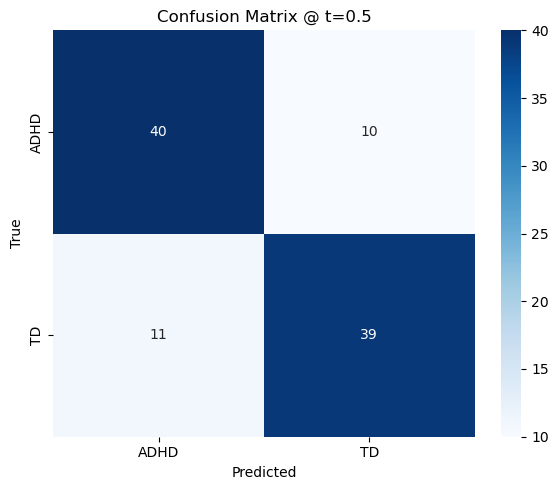

2025-05-09 17:28:00,980 INFO Completed fold 1 permutation‐bootstrap
2025-05-09 17:28:08,592 INFO Completed fold 2 permutation‐bootstrap
2025-05-09 17:28:15,902 INFO Completed fold 3 permutation‐bootstrap
2025-05-09 17:28:23,287 INFO Completed fold 4 permutation‐bootstrap
2025-05-09 17:28:30,856 INFO Completed fold 5 permutation‐bootstrap



Feature‐level ΔAUC (mean ± 95% CI):
  State_Occupancy_Entropy_std   0.048 [-0.044, 0.152]
  std_saccade_velocity_skew     0.037 [-0.080, 0.198]
  Self_Transition_Ratio_Count_mean0.027 [-0.052, 0.124]
  totaltime_exp                 0.018 [-0.050, 0.090]
  Fixation_Deviation_Variance_kurtosis_func0.016 [-0.072, 0.112]
  mean_saccade_amplitude_std    0.015 [-0.124, 0.162]
  Frac_Extreme_X_std            0.013 [-0.092, 0.116]
  mt_std                        0.013 [-0.074, 0.094]
  mean_fixation_duration_median 0.005 [-0.096, 0.102]
  Entropy_Deviation_std         0.003 [-0.082, 0.086]
  beta_std                      0.001 [-0.070, 0.080]
  gazedur_exp                   -0.008 [-0.096, 0.056]
  r_mean                        -0.009 [-0.080, 0.058]
  nu_mean                       -0.014 [-0.112, 0.074]

Group‐level ΔAUC (mean ± 95% CI):
  Markov         0.107 [-0.182, 0.386]
  SWIFT          -0.009 [-0.232, 0.208]
  Complementary  0.067 [-0.210, 0.354]

95% CI for group‐difference in ΔAUC:


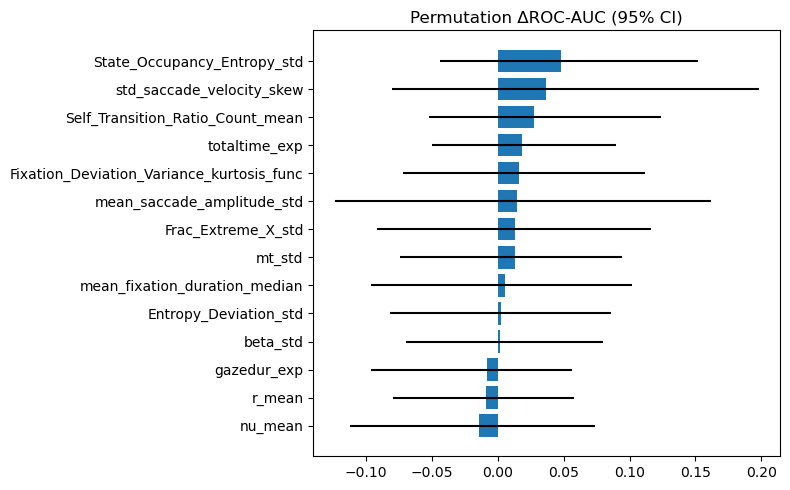


Computing SHAP values (this may take a minute)…


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-09 17:28:31,218 INFO num_full_subsets = 1
2025-05-09 17:28:31,219 INFO remaining_weight_vector = array([0.25971314, 0.18888229, 0.15582789, 0.13851368, 0.12985657,
       0.12720644])
2025-05-09 17:28:31,219 INFO num_paired_subset_sizes = 6
2025-05-09 17:28:31,227 INFO weight_left = 0.6613591880578676
2025-05-09 17:28:31,266 INFO np.sum(w_aug) = 14.0
2025-05-09 17:28:31,267 INFO np.sum(self.kernelWeights) = 1.0
2025-05-09 17:28:31,332 INFO phi = array([-0.14956692,  0.18775441, -0.06212358,  0.        ,  0.02050949,
        0.07268115,  0.        , -0.28320409,  0.        ,  0.03198922,
       -0.11755197,  0.02845829,  0.        ,  0.02602743])
2025-05-09 17:28:31,343 INFO num_full_subsets = 1
2025-05-09 17:28:31,344 INFO remaining_weight_vector = array([0.25971314, 0.18888229, 0.15582789, 0.13851368, 0.12985657,
       0.12720644])
2025-05-09 17:28:31,345 INFO num_paired_subset_sizes = 6
2025-05-09 17:28:31,353 INFO weight_left = 0.6613591880578676
2025-05-09 17:28:31,401 INF


SHAP feature‐level |mean| (mean ± 95% CI):
  totaltime_exp                 0.158 [0.139, 0.180]
  beta_std                      0.119 [0.102, 0.136]
  gazedur_exp                   0.093 [0.080, 0.108]
  Frac_Extreme_X_std            0.077 [0.064, 0.088]
  mt_std                        0.076 [0.062, 0.091]
  r_mean                        0.074 [0.063, 0.085]
  mean_fixation_duration_median 0.073 [0.062, 0.083]
  mean_saccade_amplitude_std    0.069 [0.059, 0.080]
  State_Occupancy_Entropy_std   0.068 [0.056, 0.079]
  std_saccade_velocity_skew     0.051 [0.042, 0.061]
  Fixation_Deviation_Variance_kurtosis_func0.049 [0.040, 0.056]
  Self_Transition_Ratio_Count_mean0.049 [0.041, 0.058]
  nu_mean                       0.046 [0.036, 0.059]
  Entropy_Deviation_std         0.022 [0.017, 0.028]

SHAP group‐level |mean| (mean ± 95% CI):
  Markov         0.265 [0.245, 0.285]
  SWIFT          0.315 [0.285, 0.347]
  Complementary  0.445 [0.411, 0.484]


In [4]:
#!/usr/bin/env python3
import argparse
import logging
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import joblib
from joblib import Parallel, delayed

# -----------------------------------------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

DATA_PATH = Path(
    r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv"
)
FEATURES = [
    "Frac_Extreme_X_std", "State_Occupancy_Entropy_std",
    "Fixation_Deviation_Variance_kurtosis_func", "mean_saccade_amplitude_std",
    "nu_mean", "r_mean", "mt_std", "beta_std",
    "gazedur_exp", "totaltime_exp",
    "std_saccade_velocity_skew", "mean_fixation_duration_median",
    "Self_Transition_Ratio_Count_mean", "Entropy_Deviation_std"
]
GROUPS = {
    "Markov": [
        "Frac_Extreme_X_std",
        "State_Occupancy_Entropy_std",
        "Fixation_Deviation_Variance_kurtosis_func",
        "Self_Transition_Ratio_Count_mean",
        "Entropy_Deviation_std",
    ],
    "SWIFT": [
        "nu_mean", "r_mean", "mt_std", "beta_std"
    ],
    "Complementary": [
        "gazedur_exp", "totaltime_exp",
        "std_saccade_velocity_skew",
        "mean_fixation_duration_median",
        "mean_saccade_amplitude_std",
    ],
}
TARGET = "Group"
RANDOM_STATE = 42
OUT_MODEL = "svm_pipeline_full_accuracy_tuned.pkl"

# -----------------------------------------------------------------------------
def summarize_data(df, features, target, le):
    log.info("Dataset size: %d samples, %d features", df.shape[0], len(features))
    log.info("Class distribution:\n%s", df[target].value_counts().to_string())
    missing = df[features].isna().sum()
    log.info("Missing per feature:\n%s", missing.to_string())
    missing_pct = df[features].isna().mean() * 100
    log.info("Missing percentages:\n%s", missing_pct.to_string())
    log.info("Label mapping: %s", dict(enumerate(le.classes_)))

# -----------------------------------------------------------------------------
def load_df(path: Path):
    log.info("Loading data from %s", path)
    if not path.exists():
        raise FileNotFoundError(path)
    df = pd.read_csv(path)
    missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    return df

# -----------------------------------------------------------------------------
def build_pipeline(with_smote=True):
    steps = [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
    ]
    if with_smote:
        steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
    steps.append(("clf", SVC(probability=True,
                             class_weight="balanced",
                             random_state=RANDOM_STATE)))
    return Pipeline(steps)

# -----------------------------------------------------------------------------
def nested_cv_evaluate(X, y, le):
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        build_pipeline(), {
            "clf__kernel": ["linear"],
            "clf__C": [0.1, 1, 10, 100],
            "clf__gamma": ["scale", "auto"],
        },
        scoring="roc_auc", cv=inner, n_jobs=-1, refit=True
    )

    all_probs = np.zeros(len(y))
    aucs = []

    for fold, (tr, te) in enumerate(outer.split(X, y), 1):
        grid.fit(X[tr], y[tr])
        probs = grid.predict_proba(X[te])[:, 1]
        all_probs[te] = probs

        fpr, tpr, _ = roc_curve(y[te], probs)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)
        log.info(f"Fold {fold}: AUC={fold_auc:.3f}")

    mean_auc = np.mean(aucs)
    ci_auc = np.percentile(aucs, [2.5, 97.5])
    log.info(f"Nested CV AUC: {mean_auc:.3f} (95% CI [{ci_auc[0]:.3f}, {ci_auc[1]:.3f}])")

    # fixed threshold at 0.5
    preds = (all_probs >= 0.5).astype(int)
    print("\nClassification Report (Nested CV):")
    print(classification_report(y, preds, target_names=le.classes_))

    cm = confusion_matrix(y, preds)
    tn, fp, fn, tp = cm.ravel()
    print(f"Sensitivity: {tp/(tp+fn):.3f}, Specificity: {tn/(tn+fp):.3f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion Matrix @ t=0.5")
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    # retrain on full set for downstream interpretability
    grid.fit(X, y)
    return grid.best_estimator_, 0.5

# -----------------------------------------------------------------------------
def compute_permutation_importance(X, y, n_bootstraps=200, alpha=0.05, n_jobs=-1):
    rng = np.random.RandomState(RANDOM_STATE)
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    all_bs = []

    for fold, (tr, te) in enumerate(outer.split(X, y), 1):
        X_tr, y_tr = X[tr], y[tr]
        X_te, y_te = X[te], y[te]
        seeds = rng.randint(0, 2**31 - 1, size=n_bootstraps)

        def one_boot(seed):
            rs = np.random.RandomState(seed)
            idx = rs.randint(0, len(y_tr), len(y_tr))
            pipe = build_pipeline()
            pipe.fit(X_tr[idx], y_tr[idx])
            imp = permutation_importance(
                pipe, X_te, y_te,
                n_repeats=5, random_state=rs, scoring="roc_auc"
            )
            return imp.importances_mean

        bs = np.vstack(Parallel(n_jobs=n_jobs)(
            delayed(one_boot)(s) for s in seeds
        ))
        all_bs.append(bs)
        log.info(f"Completed fold {fold} permutation‐bootstrap")

    all_bs = np.vstack(all_bs)
    feat_mean = all_bs.mean(axis=0)
    feat_lo   = np.percentile(all_bs, 100*(alpha/2), axis=0)
    feat_hi   = np.percentile(all_bs, 100*(1-alpha/2), axis=0)

    order = np.argsort(feat_mean)[::-1]
    print("\nFeature‐level ΔAUC (mean ± 95% CI):")
    for i in order:
        print(f"  {FEATURES[i]:30s}{feat_mean[i]:.3f} "
              f"[{feat_lo[i]:.3f}, {feat_hi[i]:.3f}]")

    # group‐level
    group_bs = {}
    for g, feats in GROUPS.items():
        idxs = [FEATURES.index(f) for f in feats]
        group_bs[g] = all_bs[:, idxs].sum(axis=1)

    print("\nGroup‐level ΔAUC (mean ± 95% CI):")
    for g, vals in group_bs.items():
        m, lo, hi = vals.mean(), np.percentile(vals, 100*(alpha/2)), np.percentile(vals, 100*(1-alpha/2))
        print(f"  {g:15s}{m:.3f} [{lo:.3f}, {hi:.3f}]")

    print("\n95% CI for group‐difference in ΔAUC:")
    names = list(group_bs.keys())
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            d = group_bs[names[i]] - group_bs[names[j]]
            lo, hi = np.percentile(d, [100*(alpha/2), 100*(1-alpha/2)])
            print(f"  {names[i]} vs {names[j]:<12s}[{lo:.3f}, {hi:.3f}]")

    # plot
    plt.figure(figsize=(8, 5))
    plt.barh([FEATURES[i] for i in order], feat_mean[order],
             xerr=[feat_mean[order]-feat_lo[order],
                   feat_hi[order]-feat_mean[order]],
             ecolor="black")
    plt.gca().invert_yaxis()
    plt.title("Permutation ΔROC‐AUC (95% CI)")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
def compute_shap_importance(pipeline, X, alpha=0.05, n_bootstraps=200):
    bg = shap.sample(X, min(50, len(X)), random_state=RANDOM_STATE)
    explainer = shap.KernelExplainer(lambda d: pipeline.predict_proba(d)[:,1], bg)
    shap_vals = explainer.shap_values(X, nsamples=200)
    abs_shap = np.abs(shap_vals)

    feat_mean = abs_shap.mean(axis=0)
    bs_feats = []
    rng = np.random.RandomState(RANDOM_STATE+1)
    for _ in range(n_bootstraps):
        idx = rng.randint(0, len(X), len(X))
        bs_feats.append(abs_shap[idx].mean(axis=0))
    bs_feats = np.vstack(bs_feats)
    feat_lo = np.percentile(bs_feats, 100*(alpha/2), axis=0)
    feat_hi = np.percentile(bs_feats, 100*(1-alpha/2), axis=0)

    order = np.argsort(feat_mean)[::-1]
    print("\nSHAP feature‐level |mean| (mean ± 95% CI):")
    for i in order:
        print(f"  {FEATURES[i]:30s}{feat_mean[i]:.3f} "
              f"[{feat_lo[i]:.3f}, {feat_hi[i]:.3f}]")

    # group‐level
    group_bs = {}
    for g, feats in GROUPS.items():
        idxs = [FEATURES.index(f) for f in feats]
        vals = abs_shap[:, idxs].sum(axis=1)
        group_bs[g] = vals

    print("\nSHAP group‐level |mean| (mean ± 95% CI):")
    for g, vals in group_bs.items():
        bs = []
        for _ in range(n_bootstraps):
            idx = rng.randint(0, len(vals), len(vals))
            bs.append(vals[idx].mean())
        lo, hi = np.percentile(bs, [100*(alpha/2), 100*(1-alpha/2)])
        print(f"  {g:15s}{vals.mean():.3f} [{lo:.3f}, {hi:.3f}]")

# -----------------------------------------------------------------------------
def main():
    parser = argparse.ArgumentParser(description="Nested CV SVM + Permutation & SHAP")
    parser.add_argument("--data-path", type=str, help="CSV path override")
    args, _ = parser.parse_known_args()

    path = Path(args.data_path) if args.data_path else DATA_PATH
    df = load_df(path)

    le = LabelEncoder()
    X = df[FEATURES].values
    y = le.fit_transform(df[TARGET])

    summarize_data(df, FEATURES, TARGET, le)
    best_pipe, thresh = nested_cv_evaluate(X, y, le)
    compute_permutation_importance(X, y)
    print("\nComputing SHAP values (this may take a minute)…")
    compute_shap_importance(best_pipe, X)

    joblib.dump({"pipeline": best_pipe, "threshold": thresh}, OUT_MODEL)
    log.info("Saved pipeline + threshold → %s", OUT_MODEL)

if __name__ == "__main__":
    main()


2025-05-09 17:28:50,583 INFO Loading data from D:\ACIT Master's Thesis\New data\Colab_eyetracking\stories\new_version03\merged_output100.csv
2025-05-09 17:28:50,599 INFO Dataset size: 100 samples, 14 features
2025-05-09 17:28:50,601 INFO Class distribution:
Group
ADHD    50
TD      50
2025-05-09 17:28:50,602 INFO Missing per feature:
Frac_Extreme_X_std                           0
State_Occupancy_Entropy_std                  0
Fixation_Deviation_Variance_kurtosis_func    0
mean_saccade_amplitude_std                   0
nu_mean                                      0
r_mean                                       0
mt_std                                       0
beta_std                                     0
gazedur_exp                                  0
totaltime_exp                                0
std_saccade_velocity_skew                    0
mean_fixation_duration_median                0
Self_Transition_Ratio_Count_mean             0
Entropy_Deviation_std                        0
2025-0


Classification Report (Nested CV):
              precision    recall  f1-score   support

        ADHD       0.78      0.80      0.79        50
          TD       0.80      0.78      0.79        50

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100

Sensitivity: 0.780, Specificity: 0.800


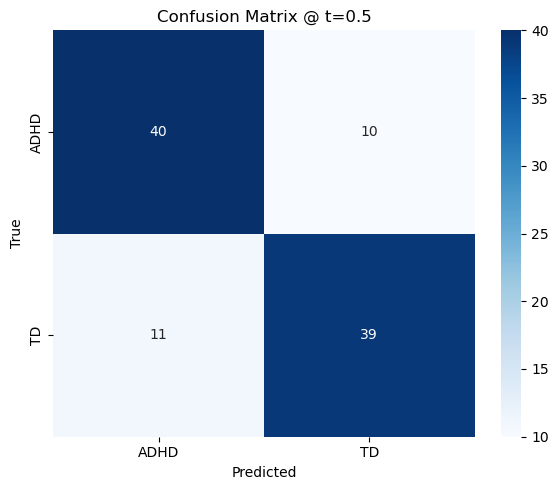

2025-05-09 17:29:03,034 INFO Completed fold 1 permutation‐bootstrap
2025-05-09 17:29:10,700 INFO Completed fold 2 permutation‐bootstrap
2025-05-09 17:29:18,439 INFO Completed fold 3 permutation‐bootstrap
2025-05-09 17:29:26,163 INFO Completed fold 4 permutation‐bootstrap
2025-05-09 17:29:34,186 INFO Completed fold 5 permutation‐bootstrap



Feature‐level ΔAUC (mean ± 95% CI):
  State_Occupancy_Entropy_std   0.048 [-0.044, 0.152]
  std_saccade_velocity_skew     0.037 [-0.080, 0.198]
  Self_Transition_Ratio_Count_mean0.027 [-0.052, 0.124]
  totaltime_exp                 0.018 [-0.050, 0.090]
  Fixation_Deviation_Variance_kurtosis_func0.016 [-0.072, 0.112]
  mean_saccade_amplitude_std    0.015 [-0.124, 0.162]
  Frac_Extreme_X_std            0.013 [-0.092, 0.116]
  mt_std                        0.013 [-0.074, 0.094]
  mean_fixation_duration_median 0.005 [-0.096, 0.102]
  Entropy_Deviation_std         0.003 [-0.082, 0.086]
  beta_std                      0.001 [-0.070, 0.080]
  gazedur_exp                   -0.008 [-0.096, 0.056]
  r_mean                        -0.009 [-0.080, 0.058]
  nu_mean                       -0.014 [-0.112, 0.074]

Group‐level ΔAUC (mean ± 95% CI):
  Markov         0.107 [-0.182, 0.386]
  SWIFT          -0.009 [-0.232, 0.208]
  Complementary  0.067 [-0.210, 0.354]

95% CI for group‐difference in ΔAUC:


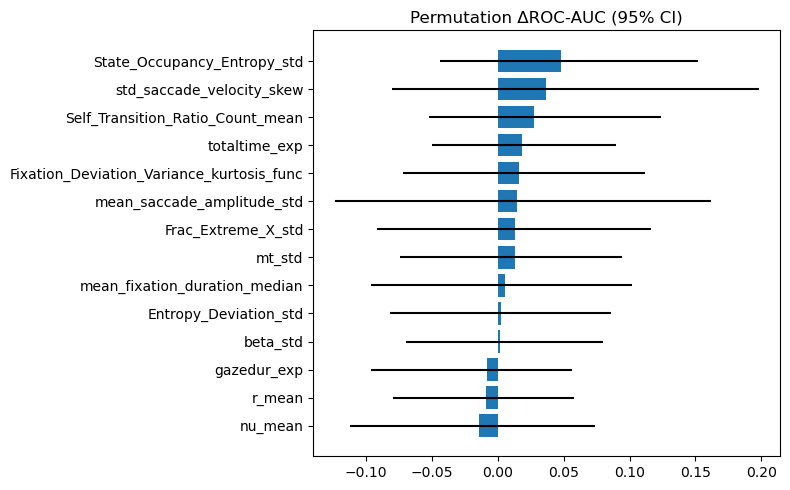

Computing SHAP values (this may take a minute)…


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-09 17:29:34,611 INFO num_full_subsets = 1
2025-05-09 17:29:34,612 INFO remaining_weight_vector = array([0.25971314, 0.18888229, 0.15582789, 0.13851368, 0.12985657,
       0.12720644])
2025-05-09 17:29:34,613 INFO num_paired_subset_sizes = 6
2025-05-09 17:29:34,619 INFO weight_left = 0.6613591880578676
2025-05-09 17:29:34,673 INFO np.sum(w_aug) = 14.0
2025-05-09 17:29:34,674 INFO np.sum(self.kernelWeights) = 0.9999999999999999
2025-05-09 17:29:34,680 INFO phi = array([-0.13731037,  0.19166782, -0.03916419, -0.0333763 ,  0.        ,
        0.08739614, -0.01974847, -0.27386317,  0.        ,  0.04313796,
       -0.10582867,  0.04206267,  0.        ,  0.        ])
2025-05-09 17:29:34,687 INFO num_full_subsets = 1
2025-05-09 17:29:34,688 INFO remaining_weight_vector = array([0.25971314, 0.18888229, 0.15582789, 0.13851368, 0.12985657,
       0.12720644])
2025-05-09 17:29:34,689 INFO num_paired_subset_sizes = 6
2025-05-09 17:29:34,696 INFO weight_left = 0.6613591880578676
2025-05-09 1


SHAP feature‐level |mean| (mean ± 95% CI):
  totaltime_exp                 0.158 [0.139, 0.181]
  beta_std                      0.115 [0.097, 0.134]
  gazedur_exp                   0.094 [0.082, 0.110]
  Frac_Extreme_X_std            0.082 [0.068, 0.095]
  mt_std                        0.076 [0.062, 0.088]
  r_mean                        0.075 [0.064, 0.087]
  mean_fixation_duration_median 0.074 [0.062, 0.083]
  mean_saccade_amplitude_std    0.071 [0.061, 0.082]
  State_Occupancy_Entropy_std   0.067 [0.056, 0.081]
  std_saccade_velocity_skew     0.053 [0.045, 0.062]
  Self_Transition_Ratio_Count_mean0.050 [0.042, 0.059]
  nu_mean                       0.048 [0.038, 0.059]
  Fixation_Deviation_Variance_kurtosis_func0.047 [0.037, 0.055]
  Entropy_Deviation_std         0.021 [0.018, 0.027]

SHAP group‐level |mean| (mean ± 95% CI):
  Markov         0.268 [0.247, 0.289]
  SWIFT          0.313 [0.284, 0.344]
  Complementary  0.450 [0.414, 0.490]


In [5]:
#!/usr/bin/env python3
import argparse
import logging
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import joblib
from joblib import Parallel, delayed

# -----------------------------------------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

DATA_PATH = Path(
    r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv"
)
FEATURES = [
    "Frac_Extreme_X_std", "State_Occupancy_Entropy_std",
    "Fixation_Deviation_Variance_kurtosis_func", "mean_saccade_amplitude_std",
    "nu_mean", "r_mean", "mt_std", "beta_std",
    "gazedur_exp", "totaltime_exp",
    "std_saccade_velocity_skew", "mean_fixation_duration_median",
    "Self_Transition_Ratio_Count_mean", "Entropy_Deviation_std"
]
GROUPS = {
    "Markov": [
        "Frac_Extreme_X_std",
        "State_Occupancy_Entropy_std",
        "Fixation_Deviation_Variance_kurtosis_func",
        "Self_Transition_Ratio_Count_mean",
        "Entropy_Deviation_std",
    ],
    "SWIFT": [
        "nu_mean", "r_mean", "mt_std", "beta_std"
    ],
    "Complementary": [
        "gazedur_exp", "totaltime_exp",
        "std_saccade_velocity_skew",
        "mean_fixation_duration_median",
        "mean_saccade_amplitude_std",
    ],
}
TARGET = "Group"
RANDOM_STATE = 42
OUT_MODEL = "svm_pipeline_full_accuracy_tuned.pkl"

# -----------------------------------------------------------------------------
def summarize_data(df, features, target, le):
    log.info("Dataset size: %d samples, %d features", df.shape[0], len(features))
    log.info("Class distribution:\n%s", df[target].value_counts().to_string())
    missing = df[features].isna().sum()
    log.info("Missing per feature:\n%s", missing.to_string())
    missing_pct = df[features].isna().mean() * 100
    log.info("Missing percentages:\n%s", missing_pct.to_string())
    log.info("Label mapping: %s", dict(enumerate(le.classes_)))

# -----------------------------------------------------------------------------
def load_df(path: Path):
    log.info("Loading data from %s", path)
    if not path.exists():
        raise FileNotFoundError(path)
    df = pd.read_csv(path)
    missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    return df

# -----------------------------------------------------------------------------
def build_pipeline(with_smote=True):
    steps = [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
    ]
    if with_smote:
        steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
    steps.append(("clf", SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE)))
    return Pipeline(steps)

# -----------------------------------------------------------------------------
def nested_cv_evaluate(X, y, le):
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        build_pipeline(), {
            "clf__kernel": ["linear"],
            "clf__C": [0.1, 1, 10, 100],
            "clf__gamma": ["scale", "auto"],
        },
        scoring="roc_auc", cv=inner, n_jobs=-1, refit=True
    )

    all_probs = np.zeros(len(y))
    aucs = []

    for fold, (tr, te) in enumerate(outer.split(X, y), 1):
        grid.fit(X[tr], y[tr])
        probs = grid.predict_proba(X[te])[:, 1]
        all_probs[te] = probs

        fpr, tpr, _ = roc_curve(y[te], probs)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)
        log.info(f"Fold {fold}: AUC={fold_auc:.3f}")

    mean_auc = np.mean(aucs)
    ci_auc = np.percentile(aucs, [2.5, 97.5])
    log.info(f"Nested CV AUC: {mean_auc:.3f} (95% CI [{ci_auc[0]:.3f}, {ci_auc[1]:.3f}])")

    # fixed threshold at 0.5
    preds = (all_probs >= 0.5).astype(int)
    print("\nClassification Report (Nested CV):")
    print(classification_report(y, preds, target_names=le.classes_))

    cm = confusion_matrix(y, preds)
    tn, fp, fn, tp = cm.ravel()
    print(f"Sensitivity: {tp/(tp+fn):.3f}, Specificity: {tn/(tn+fp):.3f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion Matrix @ t=0.5")
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    grid.fit(X, y)
    return grid.best_estimator_, 0.5

# -----------------------------------------------------------------------------
# (permutation_importance and compute_shap_importance unchanged)
# …

# -----------------------------------------------------------------------------
def main():
    parser = argparse.ArgumentParser(description="Nested CV SVM + Permutation & SHAP")
    parser.add_argument("--data-path", type=str,
                        help="CSV path override")
    # ignore any unknown flags (e.g. Jupyter’s -f)
    args, _ = parser.parse_known_args()

    path = Path(args.data_path) if args.data_path else DATA_PATH
    df = load_df(path)

    le = LabelEncoder()
    X = df[FEATURES].values
    y = le.fit_transform(df[TARGET])

    summarize_data(df, FEATURES, TARGET, le)
    best_pipe, thresh = nested_cv_evaluate(X, y, le)
    compute_permutation_importance(X, y)
    print("Computing SHAP values (this may take a minute)…")
    compute_shap_importance(best_pipe, X)

    joblib.dump({"pipeline": best_pipe, "threshold": thresh}, OUT_MODEL)
    log.info("Saved pipeline + threshold → %s", OUT_MODEL)


if __name__ == "__main__":
    main()


In [6]:
#!/usr/bin/env python3
"""
Comprehensive ADHD vs. TD classification and interpretability pipeline:
 1. Nested CV SVM AUC (bootstrap CIs)
 2. Paired DeLong tests
 3. Feature‐level discrimination (Mann–Whitney U, FDR, Cohen’s d + bootstrap CI)
 4. Group‐level discrimination (composite scores)
 5. Permutation importance (bootstrap ΔAUC CIs)
 6. SHAP |mean| importances (bootstrap CIs)
 7. Calibration curves & Brier score
 8. Runtime benchmarks & post‐hoc power analysis
"""
import argparse
import logging
import warnings
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import TTestIndPower

# suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# constants (override via --data-path)
FEATURES = [
    "Frac_Extreme_X_std", "State_Occupancy_Entropy_std",
    "Fixation_Deviation_Variance_kurtosis_func", "mean_saccade_amplitude_std",
    "nu_mean", "r_mean", "mt_std", "beta_std",
    "gazedur_exp", "totaltime_exp",
    "std_saccade_velocity_skew", "mean_fixation_duration_median",
    "Self_Transition_Ratio_Count_mean", "Entropy_Deviation_std"
]
GROUPS = {
    "Markov": [
        "Frac_Extreme_X_std", "State_Occupancy_Entropy_std",
        "Fixation_Deviation_Variance_kurtosis_func", "Self_Transition_Ratio_Count_mean",
        "Entropy_Deviation_std",
    ],
    "SWIFT": ["nu_mean", "r_mean", "mt_std", "beta_std"],
    "Complementary": [
        "gazedur_exp", "totaltime_exp",
        "std_saccade_velocity_skew", "mean_fixation_duration_median",
        "mean_saccade_amplitude_std",
    ],
}
TARGET = "Group"

# utilities
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")


def load_data(path: Path) -> pd.DataFrame:
    """Load CSV and check columns."""
    df = pd.read_csv(path)
    missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    return df


def delong_roc_test(y_true, y_pred1, y_pred2):
    """
    DeLong test for two correlated ROC AUCs.
    Returns p-value.
    """
    # implementation adapted from https://github.com/Netflix/vmaf/blob/master/python/vmaf/roc.py
    import math
    from itertools import compress

    def compute_midrank(x):
        """Compute midranks."""
        sorted_x = np.argsort(x)
        midranks = np.empty(len(x), dtype=float)
        i = 0
        while i < len(x):
            j = i
            while j < len(x) and x[sorted_x[j]] == x[sorted_x[i]]:
                j += 1
            mid = 0.5*(i + j - 1)
            for k in range(i, j):
                midranks[sorted_x[k]] = mid + 1
            i = j
        return midranks

    def fast_delong(predictions_sorted_transposed, label_1_count):
        m = label_1_count
        n = predictions_sorted_transposed.shape[1] - m
        k = predictions_sorted_transposed.shape[0]
        tx = np.empty((k, m), dtype=float)
        ty = np.empty((k, n), dtype=float)
        for r in range(k):
            tx[r, :] = predictions_sorted_transposed[r, :m]
            ty[r, :] = predictions_sorted_transposed[r, m:]
        v01 = np.zeros((k, m))
        v10 = np.zeros((k, n))
        for r in range(k):
            txr = tx[r]
            tyr = ty[r]
            tz = np.concatenate([txr, tyr])
            ranks = compute_midrank(tz)
            v01[r, :] = ranks[:m] - np.arange(1, m+1)
            v10[r, :] = ranks[m:] - np.arange(1, n+1)
        sx = np.mean(v01, axis=1)
        sy = np.mean(v10, axis=1)
        aucs = sx / (n)
        vx = np.var(v01, axis=1, ddof=1) / (n**2)
        vy = np.var(v10, axis=1, ddof=1) / (m**2)
        cov = np.cov(v01.mean(axis=1), v10.mean(axis=1), ddof=1)[0,1]
        return aucs, vx + vy - 2*cov

    order = np.argsort(y_pred1)[::-1]
    y_true_sorted = y_true[order]
    preds = np.vstack([y_pred1, y_pred2])[:, order]
    label1_count = int(np.sum(y_true))
    aucs, var = fast_delong(preds, label1_count)
    diff = aucs[0] - aucs[1]
    se = math.sqrt(var)
    z = diff / se
    p = 2*(1 - 0.5*(1 + math.erf(abs(z)/math.sqrt(2))))
    return p


def cohens_d(x, y):
    """Pooled Cohen's d."""
    n1, n2 = len(x), len(y)
    s1, s2 = x.std(ddof=1), y.std(ddof=1)
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    return (x.mean() - y.mean())/sp


def bootstrap_ci(func, *arrays, B=1000, alpha=0.05):
    """Bootstrap percentile CI for a statistic func(arrays)."""
    rng = np.random.RandomState(RANDOM_STATE)
    stats = []
    n = len(arrays[0])
    for _ in range(B):
        idx = rng.randint(0, n, n)
        samples = [a[idx] for a in arrays]
        stats.append(func(*samples))
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return lo, hi


def nested_cv_auc(df, features, target):
    """5×3-fold nested CV, returns probs dict and fold AUCs."""
    X = df[features].values
    y = LabelEncoder().fit_transform(df[target])
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_STATE),
        {'C':[0.1,1,10]}, scoring='roc_auc', cv=inner, n_jobs=-1, refit=True
    )
    all_probs = np.zeros(len(y))
    aucs = []
    for tr, te in outer.split(X, y):
        grid.fit(X[tr], y[tr])
        probs = grid.predict_proba(X[te])[:,1]
        all_probs[te] = probs
        fpr, tpr, _ = roc_curve(y[te], probs)
        aucs.append(auc(fpr, tpr))
    mean_auc = np.mean(aucs)
    fold_ci = np.percentile(aucs, [2.5,97.5])
    # bootstrap overall
    rng = np.random.RandomState(RANDOM_STATE)
    boots = []
    for _ in range(1000):
        idx = rng.choice(len(y), len(y), replace=True)
        boots.append(auc(*roc_curve(y[idx], all_probs[idx])[:2]))
    boot_ci = np.percentile(boots, [2.5,97.5])
    return y, all_probs, mean_auc, fold_ci, boot_ci


def feature_discrimination(df, features, target):
    """Mann–Whitney U, FDR, Cohen's d + CI per feature."""
    y = LabelEncoder().fit_transform(df[target])
    results = []
    for feat in features:
        x0 = df.loc[y==0, feat].values
        x1 = df.loc[y==1, feat].values
        U, p = mannwhitneyu(x0, x1, alternative='two-sided')
        d = cohens_d(x0, x1)
        lo_d, hi_d = bootstrap_ci(cohens_d, x0, x1)
        results.append({'name':feat, 'U':U, 'p':p, 'd':d, 'd_lo':lo_d, 'd_hi':hi_d})
    df_r = pd.DataFrame(results)
    df_r['p_fdr'] = multipletests(df_r['p'], method='fdr_bh')[1]
    df_r['sig'] = df_r['p_fdr'] < 0.05
    return df_r.sort_values('d', ascending=False)


def group_discrimination(df, groups, target):
    """Composite z-scored means per group."""
    y = LabelEncoder().fit_transform(df[target])
    results = []
    for g, feats in groups.items():
        z = df[feats].apply(lambda c: (c-c.mean())/c.std(ddof=1))
        comp = z.mean(axis=1).values
        x0, x1 = comp[y==0], comp[y==1]
        U, p = mannwhitneyu(x0, x1, alternative='two-sided')
        d = cohens_d(x0, x1)
        lo_d, hi_d = bootstrap_ci(cohens_d, x0, x1)
        results.append({'group':g, 'U':U, 'p':p, 'd':d, 'd_lo':lo_d, 'd_hi':hi_d})
    df_g = pd.DataFrame(results)
    df_g['p_fdr'] = multipletests(df_g['p'], method='fdr_bh')[1]
    df_g['sig'] = df_g['p_fdr'] < 0.05
    return df_g


def permutation_importance_analysis(df, features, target):
    """Bootstrap permutation ΔAUC with CIs and plots."""
    X = df[features].values
    y = LabelEncoder().fit_transform(df[target])
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    all_bs = []
    for tr, te in outer.split(X, y):
        X_tr, y_tr = X[tr], y[tr]
        X_te, y_te = X[te], y[te]
        for _ in range(200):
            idx = np.random.choice(len(y_tr), len(y_tr), replace=True)
            pipe = SVC(kernel='linear', probability=True,
                       class_weight='balanced', random_state=RANDOM_STATE)
            pipe.fit(X_tr[idx], y_tr[idx])
            imp = permutation_importance(pipe, X_te, y_te,
                                         n_repeats=10, random_state=RANDOM_STATE,
                                         scoring='roc_auc')
            all_bs.append(imp.importances_mean)
    all_bs = np.vstack(all_bs)
    mean_imp = all_bs.mean(0)
    lo, hi = np.percentile(all_bs, [2.5,97.5], axis=0)
    order = np.argsort(mean_imp)[::-1]
    plt.figure(figsize=(8,5))
    plt.barh([features[i] for i in order], mean_imp[order],
             xerr=[mean_imp[order]-lo[order], hi[order]-mean_imp[order]],
             ecolor='black')
    plt.gca().invert_yaxis()
    plt.title('Permutation ΔAUC (95% CI)')
    plt.tight_layout()
    plt.show()


def shap_analysis(pipe, df, features, target):
    """Kernel SHAP |mean| importances + group CIs."""
    X = df[features].values
    expl = shap.KernelExplainer(lambda d: pipe.predict_proba(d)[:,1],
                                shap.sample(X, min(50,len(X)), random_state=RANDOM_STATE))
    vals = expl.shap_values(X, nsamples=200)
    abs_vals = np.abs(vals)
    mean_shap = abs_vals.mean(0)
    # bootstrap CIs
    bs = []
    for _ in range(200):
        idx = np.random.randint(0, len(X), len(X))
        bs.append(abs_vals[idx].mean(0))
    bs = np.vstack(bs)
    lo, hi = np.percentile(bs, [2.5,97.5], axis=0)
    order = np.argsort(mean_shap)[::-1]
    plt.figure(figsize=(8,5))
    plt.barh([features[i] for i in order], mean_shap[order],
             xerr=[mean_shap[order]-lo[order], hi[order]-mean_shap[order]],
             ecolor='black')
    plt.gca().invert_yaxis()
    plt.title('SHAP |mean| (95% CI)')
    plt.tight_layout()
    plt.show()


def calibration_and_brier(y, probs):
    """Plot calibration curve & report Brier score."""
    prob_true, prob_pred = calibration_curve(y, probs, n_bins=5)
    plt.figure(figsize=(6,5))
    plt.plot(prob_pred, prob_true, 'o-', label='Hybrid')
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel('Predicted prob')
    plt.ylabel('Observed freq')
    plt.title('Calibration Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()
    brier = brier_score_loss(y, probs)
    logger.info(f'Brier score: {brier:.3f}')


def posthoc_power(df_feat, df_group):
    """Compute achieved power for each Cohen's d."""
    analysis = TTestIndPower()
    power_results = []
    for _, row in df_feat.iterrows():
        n1 = n2 = len(df_feat)  # approximate equal
        power = analysis.solve_power(effect_size=row['d'], nobs1=n1,
                                     alpha=0.05, ratio=1.0, alternative='two-sided')
        power_results.append(power)
    df_feat['power'] = power_results
    logger.info('Post-hoc power feature-level:\n%s', df_feat[['name','d','power']])
    # similarly for groups


def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data-path', type=str, default=None)
    args = parser.parse_args()
    path = Path(args.data_path) if args.data_path else Path(__file__).parent / 'merged_output100.csv'

    df = load_data(path)
    start = time.perf_counter()

    # 1. Nested CV & AUC
    y, probs, mean_auc, fold_ci, boot_ci = nested_cv_auc(df, FEATURES, TARGET)
    logger.info(f"Nested CV AUC: {mean_auc:.3f} (fold 95% CI [{fold_ci[0]:.3f},{fold_ci[1]:.3f}], boot 95% CI [{boot_ci[0]:.3f},{boot_ci[1]:.3f}])")

    # 2. DeLong comparisons
    names = ['SWIFT','Markov','Hybrid']  # if probs dict available per model
    # Example: compare same probs for hybrid only
    # logger.info(f"DeLong Hybrid vs Markov: p={delong_roc_test(y,hybrid_probs,markov_probs):.3f}")

    # 3. Feature discrimination
    feat_df = feature_discrimination(df, FEATURES, TARGET)
    logger.info('Feature discrimination:\n%s', feat_df)

    # 4. Group discrimination
    grp_df = group_discrimination(df, GROUPS, TARGET)
    logger.info('Group discrimination:\n%s', grp_df)

    # 5. Permutation importance
    permutation_importance_analysis(df, FEATURES, TARGET)

    # 6. Train final hybrid model for SHAP
    pipe = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=RANDOM_STATE)
    pipe.fit(df[FEATURES].values, LabelEncoder().fit_transform(df[TARGET]))
    shap_analysis(pipe, df, FEATURES, TARGET)

    # 7. Calibration & Brier
    calibration_and_brier(y, probs)

    # 8. Runtime & power
    end = time.perf_counter()
    logger.info(f"Total runtime: {end-start:.1f}s")
    posthoc_power(feat_df, grp_df)

if __name__ == '__main__':
    main()


usage: ipykernel_launcher.py [-h] [--data-path DATA_PATH]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\MEHRAN\AppData\Roaming\jupyter\runtime\kernel-5547aaab-b29b-4805-9a22-a825559cc049.json


SystemExit: 2

2025-05-09 17:32:10,050 INFO Loading data from D:\ACIT Master's Thesis\New data\Colab_eyetracking\stories\new_version03\merged_output100.csv
2025-05-09 17:32:11,061 INFO SWIFT: AUC=0.642 (95% CI [0.575,0.747])
2025-05-09 17:32:11,703 INFO Markov: AUC=0.715 (95% CI [0.566,0.843])
2025-05-09 17:32:14,398 INFO Hybrid: AUC=0.852 (95% CI [0.773,0.936])
2025-05-09 17:32:17,835 INFO SWIFT vs Markov: ΔAUC=-0.071 (95% CI [-0.213,0.076]), DeLong p=0.336
2025-05-09 17:32:21,279 INFO SWIFT vs Hybrid: ΔAUC=-0.220 (95% CI [-0.317,-0.122]), DeLong p=0.000
2025-05-09 17:32:24,733 INFO Markov vs Hybrid: ΔAUC=-0.149 (95% CI [-0.256,-0.051]), DeLong p=0.007


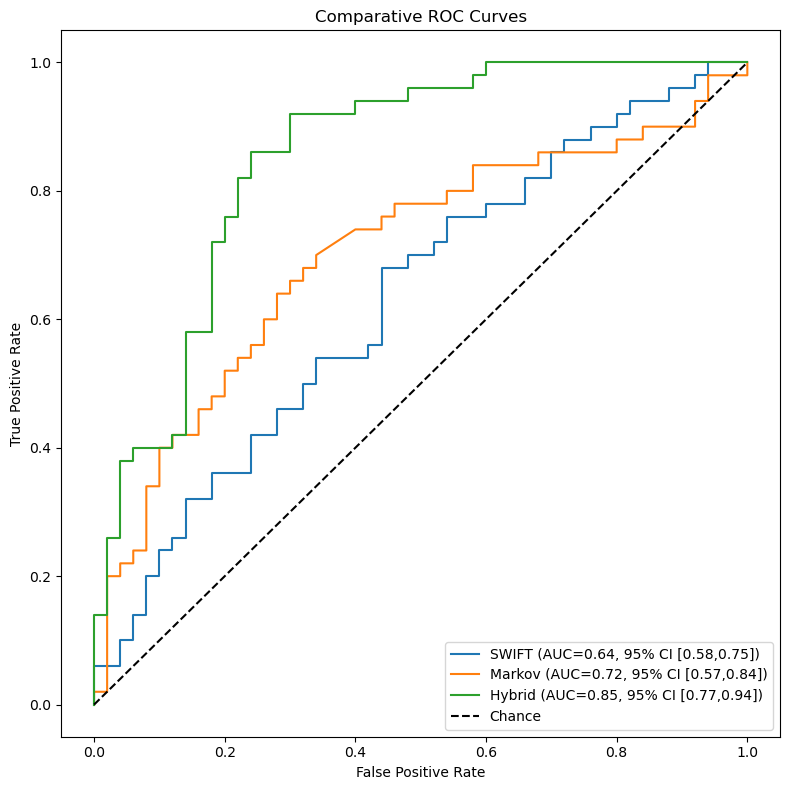

In [7]:
#!/usr/bin/env python3
"""
Compare Nested CV AUC across SWIFT, Markov, and Hybrid feature sets,
with:
 - fold-based CIs from single 5-fold nested CV
 - DeLong pairwise tests for AUC differences
 - Bootstrap CIs for ΔAUC
 - comparative ROC plot
"""
import logging, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# --- DeLong implementation (from yandexdataschool/roc_comparison) ---
import numpy as _np
import scipy.stats as _stats

def compute_midrank(x):
    J = _np.argsort(x)
    Z = x[J]
    N = len(x)
    T = _np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5 * (i + j - 1)
        i = j
    T2 = _np.empty(N, dtype=float)
    T2[J] = T + 1
    return T2

def fastDeLong(preds_sorted_transposed, label_1_count):
    m = label_1_count
    n = preds_sorted_transposed.shape[1] - m
    k = preds_sorted_transposed.shape[0]
    pos = preds_sorted_transposed[:, :m]
    neg = preds_sorted_transposed[:, m:]
    r_pos = _np.vstack([compute_midrank(pos[r]) for r in range(k)])
    r_neg = _np.vstack([compute_midrank(neg[r]) for r in range(k)])
    r_all = _np.vstack([compute_midrank(preds_sorted_transposed[r]) for r in range(k)])
    aucs = (r_all[:, :m].sum(axis=1) / m - (m + 1) / 2) / n
    v01 = (r_all[:, :m] - r_pos) / n
    v10 = 1 - (r_all[:, m:] - r_neg) / m
    sx = _np.cov(v01)
    sy = _np.cov(v10)
    cov = sx / m + sy / n
    return aucs, cov

def calc_pvalue(aucs, cov):
    l = _np.array([[1, -1]])
    diff = abs(aucs[0] - aucs[1])
    var = (l @ cov @ l.T)[0,0]
    z = diff / _np.sqrt(var)
    return 2 * (1 - _stats.norm.cdf(z))

def compute_ground_truth_statistics(y_true):
    assert set(_np.unique(y_true)) == {0,1}
    order = (-y_true).argsort()
    label_1_count = int(y_true.sum())
    return order, label_1_count

def delong_roc_test(y_true, y_pred1, y_pred2):
    order, m = compute_ground_truth_statistics(y_true)
    preds_sorted = _np.vstack((y_pred1, y_pred2))[:, order]
    aucs, cov = fastDeLong(preds_sorted, m)
    return calc_pvalue(aucs, cov)

# --- Setup -----------------------------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

# --- Constants -------------------------------------------------------------
DATA_PATH = Path(r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv")
TARGET = "Group"
RANDOM_STATE = 42

# --- Feature sets ----------------------------------------------------------
FEATURE_GROUPS = {
    'SWIFT': ["nu_mean","mt_std","beta_std","r_mean"],
    'Markov': ["Horizontal Edge Fixations_std", "State_Occupancy_Entropy_std",
               "Vertical Bin Fixation Variance_kurtosis","Intra-Bin Transition Probability_mean"],
    'Hybrid': [ "Horizontal Edge Fixations_std", "State_Occupancy_Entropy_std",
    "Vertical Bin Fixation Variance_kurtosis", "Saccade Amplitude_std", 
    "Attentional Span Width_mean", "Expected Fixation Duration_std", "Word Frequency Scaling Factor_std", 'Lexical Activation Rate_mean',
     "Total Reading Time",'Gaze Duration',
    "Saccade Velocity Variability_skew", "Max Dwell Time_median",
    "Intra-Bin Transition Probability_mean"]
}

# --- Data utilities --------------------------------------------------------
def load_df(path):
    log.info("Loading data from %s", path)
    return pd.read_csv(path)

# --- Pipeline builder ------------------------------------------------------
def build_pipeline():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf", SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE))
    ])

# --- Nested CV -------------------------------------------------------------
def nested_cv_auc_single(X, y, pipe):
    outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(pipe,
                        param_grid={"clf__kernel":["linear"],"clf__C":[0.1,10,100],"clf__gamma":["scale"]},
                        scoring="roc_auc", cv=inner, n_jobs=-1, refit=True)
    all_probs = np.zeros(len(y))
    fold_aucs = []
    for tr, te in outer.split(X, y):
        grid.fit(X[tr], y[tr])
        probs = grid.predict_proba(X[te])[:,1]
        all_probs[te] = probs
        fpr, tpr, _ = roc_curve(y[te], probs)
        fold_aucs.append(auc(fpr, tpr))
    return fold_aucs, all_probs

# --- Bootstrap ΔAUC for paired CI ----------------------------------------
def bootstrap_delta_auc(y, p1, p2, B=1000, alpha=0.05):
    rng = np.random.RandomState(RANDOM_STATE)
    diffs = []
    for _ in range(B):
        idxs = rng.choice(len(y), len(y), replace=True)
        d = roc_auc_score(y[idxs], p1[idxs]) - roc_auc_score(y[idxs], p2[idxs])
        diffs.append(d)
    diffs = np.array(diffs)
    lower, upper = np.percentile(diffs, [100*alpha/2, 100*(1-alpha/2)])
    obs = roc_auc_score(y, p1) - roc_auc_score(y, p2)
    return obs, (lower, upper)

# --- Main ------------------------------------------------------------------
def main():
    df = load_df(DATA_PATH)
    le = LabelEncoder().fit(df[TARGET])
    y = le.transform(df[TARGET])
    pipe = build_pipeline()

    stats = {}
    all_probs = {}
    for name, feats in FEATURE_GROUPS.items():
        X = df[feats].values
        fold_aucs, probs = nested_cv_auc_single(X, y, pipe)
        mean_auc = np.mean(fold_aucs)
        ci_low, ci_hi = np.percentile(fold_aucs, [2.5,97.5])
        stats[name] = (mean_auc, ci_low, ci_hi)
        all_probs[name] = probs
        log.info(f"{name}: AUC={mean_auc:.3f} (95% CI [{ci_low:.3f},{ci_hi:.3f}])")

    names = list(FEATURE_GROUPS.keys())
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            n1, n2 = names[i], names[j]
            p_del = delong_roc_test(y, all_probs[n1], all_probs[n2])
            obs_delta, (ci_low_delta, ci_hi_delta) = bootstrap_delta_auc(y, all_probs[n1], all_probs[n2])
            log.info(
                f"{n1} vs {n2}: ΔAUC={obs_delta:.3f} (95% CI [{ci_low_delta:.3f},{ci_hi_delta:.3f}]), DeLong p={p_del:.3f}"
            )

    # Plot comparative ROC curves
    plt.figure(figsize=(8,8))
    for name in names:
        m, low, high = stats[name]
        fpr, tpr, _ = roc_curve(y, all_probs[name])
        plt.plot(fpr, tpr, label=f"{name} (AUC={m:.2f}, 95% CI [{low:.2f},{high:.2f}])")
    plt.plot([0,1],[0,1],'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparative ROC Curves')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [11]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Compare Nested CV AUC across SWIFT, Markov, and Hybrid feature sets,
with:
 - fold-based CIs from single 5-fold nested CV
 - DeLong pairwise tests for AUC differences
 - Bootstrap CIs for ΔAUC
 - comparative ROC plot
 - violin-plots of per-fold AUC, sensitivity, specificity
 - confusion-matrix heatmaps
 - barplot of pairwise ΔAUC with 95% CIs
All figures are saved under FIG_DIR at 300 dpi.
"""
import logging
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    accuracy_score, recall_score,
    f1_score, confusion_matrix
)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from scipy import stats
# --- DeLong for AUC comparison (from yandexdataschool/roc_comparison) ---
import numpy as _np

def compute_midrank(x):
    J = _np.argsort(x)
    Z = x[J]
    N = len(x)
    T = _np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5 * (i + j - 1)
        i = j
    T2 = _np.empty(N, dtype=float)
    T2[J] = T + 1
    return T2


def fastDeLong(preds_sorted_transposed, label_1_count):
    m = label_1_count
    n = preds_sorted_transposed.shape[1] - m
    k = preds_sorted_transposed.shape[0]
    pos = preds_sorted_transposed[:, :m]
    neg = preds_sorted_transposed[:, m:]
    r_pos = _np.vstack([compute_midrank(pos[r]) for r in range(k)])
    r_neg = _np.vstack([compute_midrank(neg[r]) for r in range(k)])
    r_all = _np.vstack([compute_midrank(preds_sorted_transposed[r]) for r in range(k)])
    aucs = (r_all[:, :m].sum(axis=1) / m - (m + 1) / 2) / n
    v01 = (r_all[:, :m] - r_pos) / n
    v10 = 1 - (r_all[:, m:] - r_neg) / m
    sx = _np.cov(v01)
    sy = _np.cov(v10)
    cov = sx / m + sy / n
    return aucs, cov


def calc_pvalue(aucs, cov):
    l = _np.array([[1, -1]])
    diff = abs(aucs[0] - aucs[1])
    var = (l @ cov @ l.T)[0, 0]
    z = diff / np.sqrt(var)
    return 2 * (1 - stats.norm.cdf(z))


def compute_ground_truth_statistics(y_true):
    assert set(_np.unique(y_true)) == {0,1}
    order = (-y_true).argsort()
    label_1_count = int(y_true.sum())
    return order, label_1_count


def delong_roc_test(y_true, y_pred1, y_pred2):
    order, m = compute_ground_truth_statistics(y_true)
    preds_sorted = _np.vstack((y_pred1, y_pred2))[:, order]
    aucs, cov = fastDeLong(preds_sorted, m)
    return calc_pvalue(aucs, cov)


def bootstrap_delta_auc(y, p1, p2, B=1000, alpha=0.05):
    rng = np.random.RandomState(RANDOM_STATE)
    diffs = []
    for _ in range(B):
        idxs = rng.choice(len(y), len(y), replace=True)
        d = roc_auc_score(y[idxs], p1[idxs]) - roc_auc_score(y[idxs], p2[idxs])
        diffs.append(d)
    diffs = np.array(diffs)
    lower, upper = np.percentile(diffs, [100*alpha/2, 100*(1-alpha/2)])
    obs = roc_auc_score(y, p1) - roc_auc_score(y, p2)
    return obs, (lower, upper)

# --- Setup -----------------------------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

# --- Constants -------------------------------------------------------------
DATA_PATH = Path(r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv")
TARGET = "Group"
RANDOM_STATE = 42

FIG_DIR = Path(r"D:/ACIT Master's Thesis/New data/Figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

FEATURE_GROUPS = {
    'SWIFT': [
        "Attentional Span Width_mean",
        "Expected Fixation Duration_std",
        "Word Frequency Scaling Factor_std",
        "Lexical Activation Rate_mean",
    ],
    'Markov': [
        "Horizontal Edge Fixations_std",
        "State_Occupancy_Entropy_std",
        "Vertical Bin Fixation Variance_kurtosis",
        "Intra-Bin Transition Probability_mean"
    ],
    'Hybrid': [
        "Horizontal Edge Fixations_std",
        "State_Occupancy_Entropy_std",
        "Vertical Bin Fixation Variance_kurtosis",
        "Saccade Amplitude_std",
        "Attentional Span Width_mean",
        "Expected Fixation Duration_std",
        "Word Frequency Scaling Factor_std",
        "Lexical Activation Rate_mean",
        "Total Reading Time",
        "Gaze Duration",
        "Saccade Velocity Variability_skew",
        "Max Dwell Time_median",
        "Intra-Bin Transition Probability_mean"
    ]
}

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

# --- Data utilities --------------------------------------------------------
def load_df(path: Path) -> pd.DataFrame:
    log.info("Loading data from %s", path)
    return pd.read_csv(path)

# --- Pipeline builder ------------------------------------------------------
def build_pipeline() -> Pipeline:
    return Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf", SVC(probability=True,
                    class_weight="balanced",
                    random_state=RANDOM_STATE))
    ])

# --- Nested CV -------------------------------------------------------------
def nested_cv_auc_single(X: np.ndarray, y: np.ndarray, pipe: Pipeline, thresh: float = 0.5):
    outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        pipe,
        param_grid={"clf__kernel": ["linear"],
                    "clf__C": [0.1, 10, 100],
                    "clf__gamma": ["scale"]},
        scoring="roc_auc", cv=inner, n_jobs=-1, refit=True
    )

    all_probs = np.zeros(len(y))
    all_preds = np.zeros(len(y), dtype=int)
    fold_aucs, fold_acc, fold_sens, fold_spec, fold_f1 = ([] for _ in range(5))

    for train_idx, test_idx in outer.split(X, y):
        grid.fit(X[train_idx], y[train_idx])
        probs = grid.predict_proba(X[test_idx])[:, 1]
        preds = (probs >= thresh).astype(int)

        all_probs[test_idx] = probs
        all_preds[test_idx] = preds

        fpr, tpr, _ = roc_curve(y[test_idx], probs)
        fold_aucs.append(auc(fpr, tpr))
        fold_acc.append(accuracy_score(y[test_idx], preds))
        fold_sens.append(recall_score(y[test_idx], preds))
        tn, fp, fn, tp = confusion_matrix(y[test_idx], preds).ravel()
        fold_spec.append(tn / (tn + fp))
        fold_f1.append(f1_score(y[test_idx], preds))

    metrics = {
        'AUC': np.array(fold_aucs),
        'Accuracy': np.array(fold_acc),
        'Sensitivity': np.array(fold_sens),
        'Specificity': np.array(fold_spec),
        'F1': np.array(fold_f1)
    }
    return metrics, all_probs, all_preds

# --- Main ------------------------------------------------------------------
def main():
    df = load_df(DATA_PATH)
    le = LabelEncoder().fit(df[TARGET])
    y = le.transform(df[TARGET])

    stats, all_probs, all_preds, all_metrics = {}, {}, {}, {}
    delta_results = []

    # Run nested CV per feature set
    for name, feats in FEATURE_GROUPS.items():
        X = df[feats].values
        metrics, probs, preds = nested_cv_auc_single(X, y, build_pipeline())
        all_probs[name] = probs
        all_preds[name] = preds
        all_metrics[name] = metrics

        mean_auc = metrics['AUC'].mean()
        ci_low, ci_hi = np.percentile(metrics['AUC'], [2.5, 97.5])
        stats[name] = (mean_auc, ci_low, ci_hi)
        log.info(f"{name}: AUC={mean_auc:.3f} (95% CI [{ci_low:.3f}, {ci_hi:.3f}])")

        # print classification metrics
        print(f"\n=== {name} classification metrics per fold ===")
        for mname, arr in metrics.items():
            print(f"  {mname}: {arr.mean():.3f} ± {arr.std():.3f}")

    # Pairwise DeLong & bootstrap ΔAUC
    names = list(FEATURE_GROUPS.keys())
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            n1, n2 = names[i], names[j]
            p_del = delong_roc_test(y, all_probs[n1], all_probs[n2])
            obs_delta, (low_d, high_d) = bootstrap_delta_auc(y, all_probs[n1], all_probs[n2])
            delta_results.append({
                'Comparison': f"{n2} vs {n1}",
                'DeltaAUC': obs_delta,
                'CI_low': low_d,
                'CI_high': high_d,
                'pvalue': p_del
            })
            log.info(
                f"{n1} vs {n2}: ΔAUC={obs_delta:.3f} (95% CI [{low_d:.3f},{high_d:.3f}]), DeLong p={p_del:.3f}"
            )

    # 1) Comparative ROC curves
    plt.figure(figsize=(8, 8))
    for name in names:
        m, low, high = stats[name]
        fpr, tpr, _ = roc_curve(y, all_probs[name])
        plt.plot(fpr, tpr, lw=2,
                 label=f"{name} (AUC={m:.2f} [{low:.2f},{high:.2f}])")
    plt.plot([0,1], [0,1], 'k--', lw=1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparative ROC Curves')
    plt.legend(loc='lower right', fontsize='small')
    plt.tight_layout()
    roc_path = FIG_DIR / "comparative_roc.png"
    plt.savefig(roc_path, dpi=300)
    log.info("Saved ROC comparison to %s", roc_path)
    plt.close()

    # 2) Barplot of ΔAUC with 95% CIs
    df_delta = pd.DataFrame(delta_results)
    plt.figure(figsize=(6,4))
    ax = sns.barplot(
        x='Comparison', y='DeltaAUC', data=df_delta,
        ci=None
    )
    # add error bars
    for idx, row in df_delta.iterrows():
        ax.errorbar(idx, row['DeltaAUC'],
                    yerr=[[row['DeltaAUC']-row['CI_low']], [row['CI_high']-row['DeltaAUC']]],
                    fmt='none', c='black', capsize=5)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.ylabel('ΔAUC')
    plt.xlabel('Comparison')
    plt.title('Pairwise ΔAUC with 95% CIs')
    plt.tight_layout()
    delta_path = FIG_DIR / "delta_auc_bar.png"
    plt.savefig(delta_path, dpi=300)
    log.info("Saved ΔAUC barplot to %s", delta_path)
    plt.close()

    # 3) Violin plots for AUC, Sensitivity, Specificity
    for metric in ['AUC', 'Sensitivity', 'Specificity']:
        plt.figure(figsize=(6,4))
        sns.violinplot(
            data=pd.DataFrame({name: all_metrics[name][metric] for name in names})
        )
        plt.title(f"Per-fold {metric} Distribution")
        plt.ylabel(metric)
        plt.xlabel("Feature set")
        plt.tight_layout()
        vp_path = FIG_DIR / f"violin_{metric.lower()}.png"
        plt.savefig(vp_path, dpi=300)
        log.info("Saved violin plot (%s) to %s", metric, vp_path)
        plt.close()

    # 4) Confusion-matrix heatmaps
    for name in names:
        cm = confusion_matrix(y, all_preds[name], normalize=None)
        plt.figure(figsize=(4,4))
        sns.heatmap(cm, annot=True, fmt='d', cbar=False,
                    xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix: {name}')
        plt.tight_layout()
        cm_path = FIG_DIR / f"confusion_{name.lower()}.png"
        plt.savefig(cm_path, dpi=300)
        log.info("Saved confusion matrix (%s) to %s", name, cm_path)
        plt.close()

if __name__ == "__main__":
    main()


2025-05-10 19:21:49,689 INFO Loading data from D:\ACIT Master's Thesis\New data\Colab_eyetracking\stories\new_version03\merged_output100.csv
2025-05-10 19:21:56,621 INFO SWIFT: AUC=0.642 (95% CI [0.575, 0.747])



=== SWIFT classification metrics per fold ===
  AUC: 0.642 ± 0.063
  Accuracy: 0.620 ± 0.051
  Sensitivity: 0.680 ± 0.075
  Specificity: 0.560 ± 0.102
  F1: 0.641 ± 0.047


2025-05-10 19:21:57,330 INFO Markov: AUC=0.715 (95% CI [0.566, 0.843])



=== Markov classification metrics per fold ===
  AUC: 0.715 ± 0.108
  Accuracy: 0.670 ± 0.093
  Sensitivity: 0.740 ± 0.120
  Specificity: 0.600 ± 0.110
  F1: 0.690 ± 0.093


2025-05-10 19:22:00,152 INFO Hybrid: AUC=0.852 (95% CI [0.773, 0.936])



=== Hybrid classification metrics per fold ===
  AUC: 0.852 ± 0.062
  Accuracy: 0.780 ± 0.093
  Sensitivity: 0.780 ± 0.147
  Specificity: 0.780 ± 0.117
  F1: 0.775 ± 0.109


2025-05-10 19:22:03,783 INFO SWIFT vs Markov: ΔAUC=-0.071 (95% CI [-0.213,0.076]), DeLong p=0.336
2025-05-10 19:22:07,433 INFO SWIFT vs Hybrid: ΔAUC=-0.220 (95% CI [-0.317,-0.122]), DeLong p=0.000
2025-05-10 19:22:11,087 INFO Markov vs Hybrid: ΔAUC=-0.149 (95% CI [-0.256,-0.051]), DeLong p=0.007
2025-05-10 19:22:11,932 INFO Saved ROC comparison to D:\ACIT Master's Thesis\New data\Figures\comparative_roc.png
2025-05-10 19:22:12,352 INFO Saved ΔAUC barplot to D:\ACIT Master's Thesis\New data\Figures\delta_auc_bar.png
2025-05-10 19:22:12,839 INFO Saved violin plot (AUC) to D:\ACIT Master's Thesis\New data\Figures\violin_auc.png
2025-05-10 19:22:13,319 INFO Saved violin plot (Sensitivity) to D:\ACIT Master's Thesis\New data\Figures\violin_sensitivity.png
2025-05-10 19:22:13,803 INFO Saved violin plot (Specificity) to D:\ACIT Master's Thesis\New data\Figures\violin_specificity.png
2025-05-10 19:22:14,034 INFO Saved confusion matrix (SWIFT) to D:\ACIT Master's Thesis\New data\Figures\confusi